#Notes from email
In the attached dataset (rename tgzd_csv to tgz) you will find some labelled data, some unlabelled data, and a text file describing the columns. With this data there are many things you could do. Pick one of the following questions or formulate your own.

1. What are the customers saying about their delivery experience? Are there trends or themes?
2. Build a predictive machine to evaluate feedback and flag potential problems.
3. Evaluate the effectiveness of the survey and questions for identifying problems.

Notes:
0. There is no hard time limit. Please work on it when you get a chance. Don't spend too much time working on it.
1. Please reach out for clarification if something is not clear.
2. This dataset is sensitive and private. Please do not distribute it or post to any public location.
3. Upon completion of the challenge, we request you delete the dataset.


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn import cross_validation 
sns.set()
%matplotlib inline

In [2]:
column_names="""short_comment, dbio_verid, dbio_lastchanged, dbio_created_by, score_value, long_comment,  ccare_required, dbio_rowid, dbio_created_on, unique_id, status, status_code, delivery_date, delivery_date_tz,  ship_date_tz, ship_date, eta_date, eta_date_tz, overall_score, packaging_score, itemcond_score, uidesign_score, received_on, received_on_tz"""
column_names = re.split('\W+',column_names)
pd.options.display.max_columns= len(column_names) + 10

In [3]:
feedback = pd.read_csv('feedback_data/feedback.csv')
feedback.columns = column_names

In [4]:
sentdf = pd.read_csv('feedback_data/sentiment_graded.csv')

In [5]:
feedback.long_comment = feedback.long_comment.str.lower()
feedback.long_comment = feedback.long_comment.replace({'\n':' '},regex=True)
sentdf.long_comment = sentdf.long_comment.replace({'\n':' '},regex=True)

In [6]:
# lots of overlap when people just say 'good' or 'good job' or whatever so trying to avoid for join
sentdf.drop_duplicates('long_comment', inplace=True)

In [7]:
sentdf.shape
#should be (1501,2)

(1501, 2)

In [8]:
df = feedback
df = pd.merge(feedback, sentdf, on='long_comment', how='left')
# clear feedback if needed, just memory issue
feedback = None

In [9]:
df.drop(['dbio_created_by','score_value'],inplace=True,axis=1)
df.shape
#should be 530793,23 after dropping rows but before adding of additional features

(530793, 23)

###Columns with no values:
* dbio_created_by
* score_value

####other notes:
* tracking number included in unique_id
* no idea what difference between 'delivered' and 'received' for those two columns, just going to use delivered

In [10]:
# for x in range(df.shape[1]):
#     print('column name: '+ df.columns[x] )
#     print(len(df[df.iloc[:,x].notnull()]))
#     print('\n')

In [11]:
#len of long_comment
df['length_comment'] = df[df.long_comment.notnull()].long_comment.map(lambda x: len(x))

In [12]:
# grab the fedex shipping type from tracking number, maybe indicitive of customer
df['shipping_type'] = df[df.unique_id.notnull()].unique_id.map(lambda x: x.split('~')[2])
df['tracking_numbers'] = df[df.unique_id.notnull()].unique_id.map(lambda x: x.split('~')[1])

# not sure what to do with first number from unique_id
# is somewhat close to ship date but not exact
# example 20150210200600  
#         2015|02|10|20|06|00
#         | Y |M | D| H| M| S
# and ship date was same day but different time
# df['timeunknown'] = df[df.unique_id.notnull()].unique_id.map(lambda x: x.split('~')[0])
# timeunknown=pd.get_dummies(df.timeunknown)

In [13]:
df = df.join(pd.get_dummies(df.shipping_type))

In [14]:
df = df.join(pd.get_dummies(df.short_comment))
# status is not helpful since too much peripheral
# df = df.join(pd.get_dummies(df.status))

In [15]:
df.delivery_date = pd.to_datetime(df.delivery_date)
df.ship_date = pd.to_datetime(df.ship_date)
df.eta_date = pd.to_datetime(df.eta_date)
# df.sort('ship_date')

In [16]:
print('# of rows with sentiment score of each:\n',df.sentiment.value_counts())

print('\n # of rows with ccare_required count:\n', df.ccare_required.value_counts())

# of rows with sentiment score of each:
 0    2982
1     722
dtype: int64

 # of rows with ccare_required count:
 1     227825
2      11549
3       1033
4        139
5         36
6         10
7          6
10         5
8          4
20         1
16         1
13         1
12         1
11         1
9          1
dtype: int64


###Looking at Trends:
what effect does missing the eta delivery date (from actual delivery date) have on overall score or sentiment?
* __
###small interesting notes:
* big discrepency between customer and carrier information it seems?  (i.e. if short_comment=='Not yet delivered'): status can say delivered 
>> df[(df.short_comment=='Not yet delivered') & (df.status =='Delivered')] 

* status feature values don't make sense

* Alot of the data just very inconsistent if it was presummably pulled from some database, probably would be useful to have "standardized" normalization. 

* eta_date seem's like it may be highly inaccurate (i.e. order's with delivery errors of 100+ days)

In [45]:
df.head(3)

dbio_verid                  dbio_lastchanged  ccare_required  dbio_rowid  \
266           1  2015-03-27 03:13:29.239000+00:00               1     1043347   
267           0  2015-04-13 16:18:31.519853+00:00               1     1091345   
268           6  2015-04-11 10:41:40.568000+00:00               1     1087824   

                      dbio_created_on         status       delivery_date  \
266  2015-03-27 03:13:20.307816+00:00      Delivered 2015-03-26 17:09:00   
267  2015-04-13 16:18:31.519853+00:00  Just Shipped! 2015-03-26 17:09:00   
268  2015-04-11 10:40:11.559548+00:00      Delivered 2015-04-10 17:18:00   

     ship_date                   eta_date  overall_score  sentiment  \
266 2015-03-20  2015-03-26 00:00:00+00:00              5          0   
267 2015-04-03  2015-04-07 00:00:00+00:00              5          0   
268 2015-04-09  2015-04-07 00:00:00+00:00              5          0   

     length_comment tracking_numbers  FDEG  FX  FXSP  Not yet delivered  \
266               4  017461882839902     0   0     0                  0   
267               4  017461882839902     0   0     0                  0   
268               5  017461882839902     0   0     0                  0   

     early  late  ontime           etaerror  etadays  
266      0     0       0    0 days 17:09:00        0  
267      0     0       0 -12 days +17:09:00      -12  
268      0     0       1    3 days 17:18:00        3

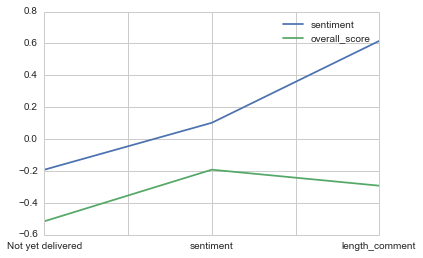

In [17]:
sns.set_style("whitegrid")
df[['overall_score','Not yet delivered', 'sentiment','length_comment']].corr().sentiment.drop('sentiment').plot()
df[['overall_score','Not yet delivered', 'sentiment','length_comment']].corr().overall_score.drop('overall_score').plot()
plt.legend()

In [18]:
df[['overall_score','Not yet delivered', 'sentiment','length_comment']].corr()

overall_score  Not yet delivered  sentiment  length_comment
overall_score           1.000000          -0.514996  -0.191546       -0.291937
Not yet delivered      -0.514996           1.000000   0.102684       -0.007956
sentiment              -0.191546           0.102684   1.000000        0.616227
length_comment         -0.291937          -0.007956   0.616227        1.000000

In [19]:
df.overall_score.value_counts()

5    119014
1     17417
4     16680
3      8375
2      4479
0        14
dtype: int64

Going off of above, best guess to create predictive model with minimal features (not having to do feature selection and data imputation or worrying about various other things).  Simple classification model and simple 4 fold CV score with no real feature engineering or model validation since the actual "features" are most likely meaningless (i.e. can't base an overall_score on a long_comment score which are most likely left a the same time)

In [20]:
x_train,x_test,y_train,y_test = cross_validation.train_test_split(df[df['Not yet delivered'].notnull() & df.length_comment.notnull() & df.sentiment.notnull() & df.overall_score][['Not yet delivered', 'length_comment','sentiment']],df[df['Not yet delivered'].notnull() & df.length_comment.notnull() & df.sentiment.notnull() & df.overall_score][['overall_score']], test_size=0.2)
rfc1 = RandomForestClassifier(n_estimators=1000, random_state=666)
rfc1.fit(x_train,np.ravel(y_train))
rfc1.score(x_test,np.ravel(y_test))
scores1 = cross_validation.cross_val_score(rfc1, x_test,np.ravel(y_test), cv=3)
print("accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

accuracy: 0.90 (+/- 0.02)


In [21]:
#dropping some more things at this point to make fillna and dropna work better
df = df.drop(['eta_date_tz','received_on','received_on_tz','shipping_type','unique_id','short_comment','long_comment','delivery_date_tz','ship_date_tz','packaging_score','itemcond_score','uidesign_score','status_code'],axis=1)
# fill in some missing data, questionable on how much this alters
df = df.fillna(method='pad').dropna(axis=0)

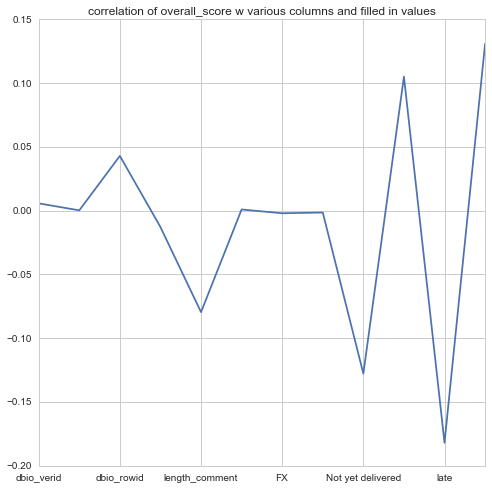

In [22]:
plt.figure(figsize=(8,8))
df.corr().overall_score.drop('overall_score').plot()
plt.title('correlation of overall_score w various columns and filled in values')

In [23]:
## Just for fun, 2 regression models below, but pretty meaningless results/models
# rfm = RandomForestRegressor(n_estimators=250)
# rfm.fit(x_train,np.ravel(y_train))
# rfm.score(x_test,np.ravel(y_test))
# # scores = cross_validation.cross_val_score(rfm, x_test,np.ravel(y_test), cv=10)
# # print("accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# lm = LinearRegression()
# x_train,x_test,y_train,y_test = cross_validation.train_test_split(df[df['Not yet delivered'].notnull() & df.length_comment.notnull() & df.sentiment.notnull() & df.overall_score][['Not yet delivered', 'length_comment','sentiment']],df[df['Not yet delivered'].notnull() & df.length_comment.notnull() & df.sentiment.notnull() & df.overall_score][['overall_score']], test_size=0.2)
# lm.fit(x_train,y_train)
# lm.score(x_test,y_test)
# # scores = cross_validation.cross_val_score(lm, x_train,y_train, cv=10)
# # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [24]:
df.drop(df[df.eta_date.str.contains("20")==False].index,axis=0,inplace=True)
df['etaerror'] = pd.to_datetime(df.delivery_date) - pd.to_datetime(df.eta_date)

In [25]:
df['etadays'] = df.etaerror.dt.days

In [26]:
x_train,x_test,y_train,y_test = cross_validation.train_test_split(df.drop(["dbio_rowid","overall_score","status","etaerror", "dbio_lastchanged","dbio_created_on","delivery_date","ship_date","eta_date","tracking_numbers"],axis=1),df.overall_score, test_size=0.4)
rfc = RandomForestClassifier(n_estimators=1000, random_state=666,n_jobs=-1)
rfc.fit(x_train,np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=666, verbose=0, warm_start=False)

In [27]:
print("score: ", rfc.score(x_test,np.ravel(y_test)))
scores = cross_validation.cross_val_score(rfc, x_test,np.ravel(y_test), cv=5)
print("accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#rfc.feature_importances_

score:  0.681330229402
accuracy: 0.68 (+/- 0.00)


In [44]:
columnsused = list(df.drop(["dbio_rowid","overall_score","status","etaerror", "dbio_lastchanged","dbio_created_on","delivery_date","ship_date","eta_date","tracking_numbers"],axis=1).columns)
featimportance = rfc.feature_importances_

print("list of features and importance for model overall:\n\n")
for x in np.argsort(featimportance)[::-1]:
    print("feature: ", columnsused[x], "\nimportance: ", featimportance[x], "\n")

list of features and importance for model overall:


feature:  length_comment 
importance:  0.480128815165 

feature:  etadays 
importance:  0.354504061367 

feature:  dbio_verid 
importance:  0.0783956686559 

feature:  late 
importance:  0.0278709876466 

feature:  Not yet delivered 
importance:  0.0147960192474 

feature:  ontime 
importance:  0.0107899130417 

feature:  early 
importance:  0.00991875098433 

feature:  ccare_required 
importance:  0.0095576520737 

feature:  sentiment 
importance:  0.00452661111701 

feature:  FXSP 
importance:  0.00434708410619 

feature:  FDEG 
importance:  0.00355488844709 

feature:  FX 
importance:  0.00160954814753 



###final remarks
going off of this, 
error of expected delivery versus date delivered seem's to be important.  Accuracy of the model is not "great" but seem's precise.  Also, I know that is not the entirely correct way to evaluate a score with CV but my computer isn't able to do the memory requirements/speed of what I think I would have to do.